In [1]:
from scipy import signal
%cd /Users/tsimpson/Documents/githubPages/tomsimpson74.github.io/Tutorials/VAE_NNM/Data
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(tf.__version__)

/Users/tsimpson/Documents/githubPages/tomsimpson74.github.io/Tutorials/VAE_NNM/Data


ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
from glob import glob
filelist = glob('**/LANL_state_12_original_accelerations_M_*.csv',recursive=True)
YY = [] 
for file in filelist:
  YY.append(np.loadtxt(open(file,"rb"), delimiter=","))
y = np.concatenate(YY,axis=0)
print(y.shape)
#y = signal.detrend(y)
nx = y.shape[0]/50
print(nx)

ymax=y.max(axis=0,keepdims=True)
ymin=y.min(axis=0,keepdims=True)
ynorm = 2*(y-ymin)/(ymax-ymin)-1

for i in range(50):
  YY[i]=2*(YY[i]-ymin)/(ymax-ymin)-1

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(ynorm)
YZ = []
for i in range(50):
  YZ.append(pca.fit_transform(YY[i]))

yz = pca.fit_transform(ynorm)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))


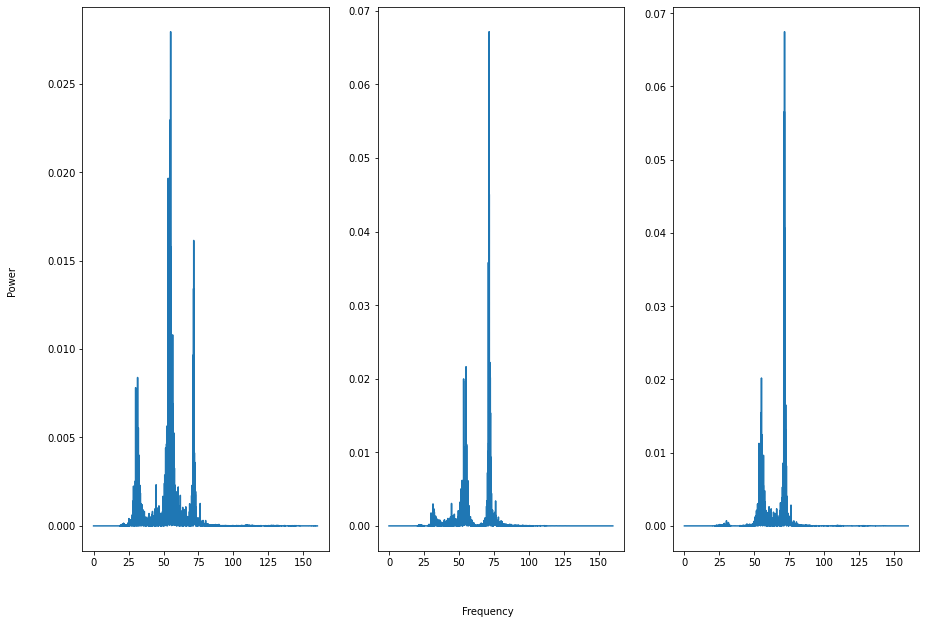

In [ ]:
from math import floor, ceil, log

window ='hann'
nperseg = floor(y.shape[0]/8)
nfft = 2**(ceil(log(nperseg,2)))



f, axs = plt.subplots(1,3,figsize=(15,10))
for i, ax in enumerate(f.axes):
  PSD =[]
  for j in range(13,14):   
    freqs, psd = signal.welch(YY[j][:,i-1],fs=320, nperseg=nperseg,window=window,nfft=nfft)
    PSD.append(np.reshape(psd,(psd.shape[0],1)))
  PSD=np.concatenate(PSD,axis=1)
  PSD = np.mean(PSD,axis=1)
  ax.plot(freqs,PSD)
f.text(0.5, 0.04, 'Frequency', ha='center', va='center')
f.text(0.06, 0.5, 'Power', ha='center', va='center', rotation='vertical')

np.save('zpca.npy',YZ[13])

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 3
act = 'tanh'

encoder_inputs = keras.Input(shape=(y.shape[1]))
x = layers.Dense(40, activation=act)(encoder_inputs)
x = layers.Dense(32, activation=act)(x)
z_mean = layers.Dense(latent_dim,activation='linear', name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, activation='linear', name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 40)           160         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           1312        ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 3)            99          ['dense_1[0][0]']                
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation=act)(latent_inputs)
x = layers.Dense(40, activation=act)(x)
decoder_outputs = layers.Dense(y.shape[1], activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                128       
                                                                 
 dense_3 (Dense)             (None, 40)                1320      
                                                                 
 dense_4 (Dense)             (None, 3)                 123       
                                                                 
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KLweight, CORweight, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.KLweight = KLweight
        self.CORweight = CORweight
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.epoch=0
        self.corr_loss_tracker = keras.metrics.Mean(name='corr_loss')
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.corr_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(0)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            corr_loss = tf.math.abs(tfp.stats.covariance(z[:,0:1],z[:,1:2]))+tf.math.abs(tfp.stats.covariance(z[:,0:1],z[:,2:3]))+tf.math.abs(tfp.stats.covariance(z[:,1:2],z[:,2:3]))
            total_loss = reconstruction_loss + self.KLweight*kl_loss+self.CORweight*corr_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.corr_loss_tracker.update_state(corr_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "corr_loss": self.corr_loss_tracker.result(),
        }

def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [ ]:
%load_ext tensorboard
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
!rm -rf ./logs/ 

In [ ]:
from scipy import signal
L = []
z = []
for j in range(1):
  #reset_weights(vae)
  weightsFile = 'wts_'+str(j)+'.tf'
  weight = [0,0.1,0.2,0.5,1,2]
  weight = [15]
  WW = [10, 100, 500, 1000, 5000, 10000]
  WW = [10000]
  
  for i in range(len(WW)):
    print(WW[i])
    vae = VAE(encoder, decoder, weight[0], WW[i])
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    usualCallback = EarlyStopping(monitor='loss', min_delta=1e-9, patience = 250, restore_best_weights=True)
    #vae.load_weights('goodwts100hiddenlayer.hdf5')
    #vae.load_weights(weightsFile)
    vae.fit(y[:8192,:], epochs=2000, batch_size=1024, callbacks=[usualCallback,tensorboard_callback])

  #vae.save_weights(weightsFile)

  z.append(vae.encoder.predict(ynorm[:,:])[2])


10000
Epoch 1/2000
8/8 [==============================] - 2s 26ms/step - loss: 147.5222 - reconstruction_loss: 15.2306 - kl_loss: 7.5249 - corr_loss: 0.0019
Epoch 2/2000
8/8 [==============================] - 0s 22ms/step - loss: 145.5567 - reconstruction_loss: 15.7333 - kl_loss: 7.5053 - corr_loss: 0.0018
Epoch 3/2000
8/8 [==============================] - 0s 20ms/step - loss: 144.6025 - reconstruction_loss: 15.8491 - kl_loss: 7.4854 - corr_loss: 0.0016
Epoch 4/2000
8/8 [==============================] - 0s 20ms/step - loss: 142.0202 - reconstruction_loss: 15.9152 - kl_loss: 7.4643 - corr_loss: 0.0016
Epoch 5/2000
8/8 [==============================] - 0s 20ms/step - loss: 143.7029 - reconstruction_loss: 16.1750 - kl_loss: 7.4444 - corr_loss: 0.0017
Epoch 6/2000
8/8 [==============================] - 0s 20ms/step - loss: 145.4315 - reconstruction_loss: 16.3332 - kl_loss: 7.4267 - corr_loss: 0.0015
Epoch 7/2000
8/8 [==============================] - 0s 22ms/step - loss: 138.1988 - reco

In [ ]:
vae.fit(y[:8192,:], epochs=2000, batch_size=1024, callbacks=[usualCallback,tensorboard_callback])

Epoch 1/2000
8/8 [==============================] - 0s 28ms/step - loss: 34.8487 - reconstruction_loss: 5.0474 - kl_loss: 15.5357 - corr_loss: 5.7632e-05
Epoch 2/2000
8/8 [==============================] - 0s 20ms/step - loss: 33.9298 - reconstruction_loss: 5.0212 - kl_loss: 15.5392 - corr_loss: 5.6010e-05
Epoch 3/2000
8/8 [==============================] - 0s 39ms/step - loss: 33.9850 - reconstruction_loss: 5.0652 - kl_loss: 15.5418 - corr_loss: 6.0199e-05
Epoch 4/2000
8/8 [==============================] - 0s 22ms/step - loss: 36.9233 - reconstruction_loss: 5.0824 - kl_loss: 15.5439 - corr_loss: 8.7847e-05
Epoch 5/2000
8/8 [==============================] - 0s 22ms/step - loss: 37.8004 - reconstruction_loss: 5.0149 - kl_loss: 15.5460 - corr_loss: 1.0068e-04
Epoch 6/2000
8/8 [==============================] - 0s 33ms/step - loss: 34.1657 - reconstruction_loss: 5.0311 - kl_loss: 15.5483 - corr_loss: 6.0737e-05
Epoch 7/2000
8/8 [==============================] - 0s 18ms/step - loss: 35.

In [ ]:
#zzz=np.corrcoef(z[0].T)
#print(zzz)
#vae.save_weights('goodwts100hiddenlayer.tf')
vae.built=True
vae.load_weights('goodwts100hiddenlayer.hdf5')

ValueError: ignored

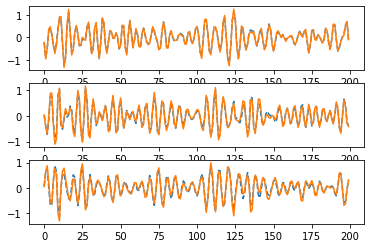

In [ ]:
k = 20
z = vae.encoder.predict(y[k*8192:(k+1)*8192,:])[0]
ypred = vae.decoder.predict(z)
plt.subplot(3,1,1)
plt.plot(ypred[:200,0],'--')
plt.plot(y[k*8192:k*8192+200,0])
plt.subplot(3,1,2)
plt.plot(ypred[:200,1],'--')
plt.plot(y[k*8192:k*8192+200,1])
plt.subplot(3,1,3)
plt.plot(ypred[:200,2],'--')
plt.plot(y[k*8192:k*8192+200,2])

#vae.save_weights('4040enc_4040dec_beta1.tf')
np.save('z.npy',z)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 51200 is greater than input length  = 8192, using nperseg = 8192
  .format(nperseg, input_length))


Text(0.06, 0.5, 'Power')

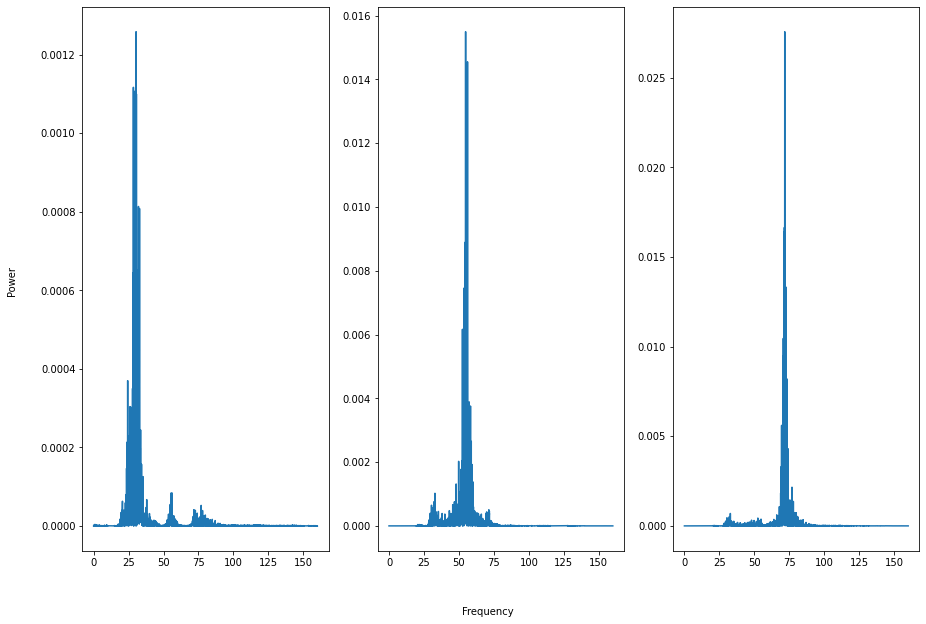

In [ ]:

f, axs = plt.subplots(1,3,figsize=(15,10))
for i, ax in enumerate(f.axes):
  freqs, psd = signal.welch(z[:,i-1],fs=320, nperseg=nperseg,window=window,nfft=nfft)
  ax.plot(freqs,psd)
f.text(0.5, 0.04, 'Frequency', ha='center', va='center')
f.text(0.06, 0.5, 'Power', ha='center', va='center', rotation='vertical')

In [ ]:
from scipy.integrate import odeint


def f(y, t, params):
    y1, y2, y3, y4, y5, y6 = y
    k, c, m, knl, F, ts = params
    i = floor(t/ts)
    f=F[i]
    derivs=[y2,
           (f-2*c*y2+c*y4-2*k*y1+k*y3-knl*y1**3)/m,
            y4,
            (0-2*c*y4+c*y2+c*y6-2*k*y3+k*y1+k*y5)/m,
            y6,
            (0-c*(y6-y4)-k*(y5-y3)-c*y6-k*y5)/m
            ]

    return derivs

tStop = 1000
ts = 0.01
t = np.arange(0., tStop, ts)
nt = len(t)


np.random.seed(1)
#Parameters
k = 10
c = 0.1
m = 1
knl = 1500
F = (5**0.5)*np.random.randn(nt+1)
print(F.shape)
print(t.shape)

params=[k, c, m, knl, F, ts]

#Initial values
y1_0=0
y2_0=0
y3_0=0
y4_0=0
y5_0=0
y6_0=0
y0 = [y1_0, y2_0, y3_0, y4_0, y5_0, y6_0]


psoln = odeint(f, y0, t, args=(params,))


(100001,)
(100000,)


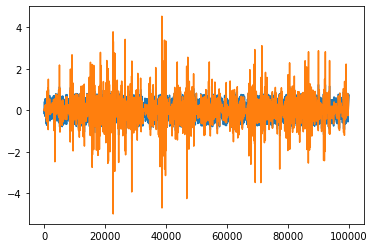

In [ ]:
y = psoln[:,[0,2,4]]
plt.plot(y[:,0]*k)
plt.plot(y[:,0]**3*knl)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
yz = pca.fit_transform(y[:,:])
yzmax=yz.max(axis=0,keepdims=True)
yzmin=yz.min(axis=0,keepdims=True)
yz = 2*(yz-yzmin)/(yzmax-yzmin)-1


In [ ]:
ymax=y.max(axis=0,keepdims=True)
ymin=y.min(axis=0,keepdims=True)
y = 2*(y-ymin)/(ymax-ymin)-1

Text(0.06, 0.5, 'Power')

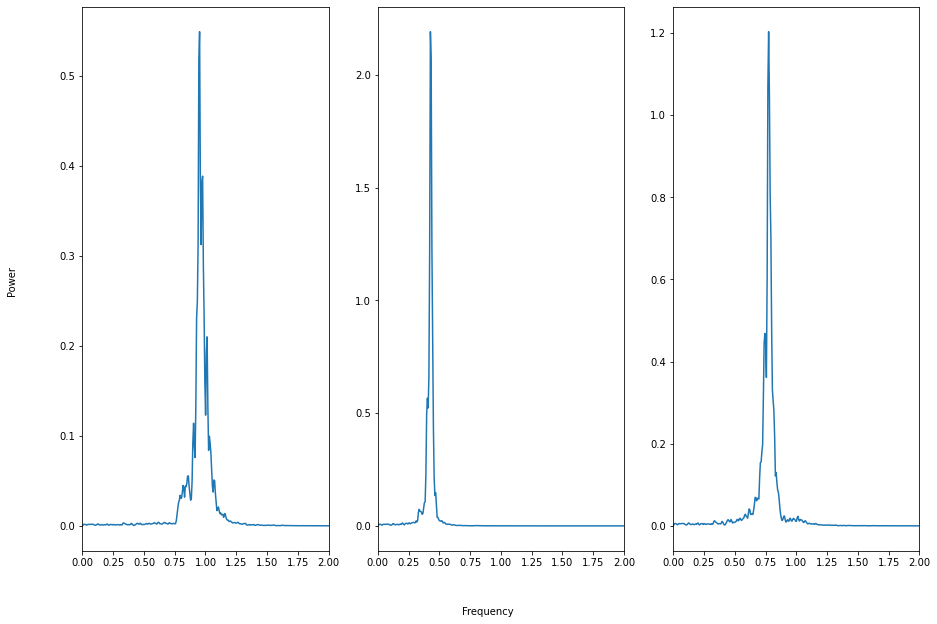

In [ ]:
from math import floor, ceil, log
fs =100
window ='hann'
nperseg = floor(y.shape[0]/8)
nfft = 2**(ceil(log(nperseg,2)))


f, axs = plt.subplots(1,3,figsize=(15,10))
for i, ax in enumerate(f.axes):
  freqs, psd = signal.welch(yz[:,i-1],fs=100,window=window,nperseg=nperseg,nfft=nfft)
  ax.plot(freqs,psd)
  ax.set_xlim(0, 2)
f.text(0.5, 0.04, 'Frequency', ha='center', va='center')
f.text(0.06, 0.5, 'Power', ha='center', va='center', rotation='vertical')

In [ ]:
L = []
for j in range(1):
  #reset_weights(vae)
  weightsFile = 'wts_'+str(j)+'.tf'
  #weight = [0,0.1,0.2,0.5,0.75]
  weight = [1]

  for i in range(len(weight)):
    print(weight[i])
    vae = VAE(encoder, decoder, weight[i])
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    usualCallback = EarlyStopping(monitor='loss', min_delta=1e-9, patience = 50, restore_best_weights=True)
    #vae.load_weights(weightsFile)
    vae.fit(yz[:3000,:], epochs=500, batch_size=64, callbacks=[usualCallback,tensorboard_callback])

  vae.save_weights(weightsFile)

  z = vae.encoder.predict(y[:3000,:])[2]

1
Epoch 1/500
47/47 [==============================] - 2s 11ms/step - loss: 2.5799 - reconstruction_loss: 1.9505 - kl_loss: 0.5100 - corr_loss: 0.2957
Epoch 2/500
47/47 [==============================] - 0s 4ms/step - loss: 2.2681 - reconstruction_loss: 1.6786 - kl_loss: 0.5403 - corr_loss: 0.3924
Epoch 3/500
47/47 [==============================] - 0s 4ms/step - loss: 2.1357 - reconstruction_loss: 1.5396 - kl_loss: 0.6114 - corr_loss: 0.4335
Epoch 4/500
47/47 [==============================] - 0s 4ms/step - loss: 2.0430 - reconstruction_loss: 1.4297 - kl_loss: 0.6503 - corr_loss: 0.4141
Epoch 5/500
47/47 [==============================] - 0s 4ms/step - loss: 2.1031 - reconstruction_loss: 1.4029 - kl_loss: 0.6587 - corr_loss: 0.3937
Epoch 6/500
47/47 [==============================] - 0s 4ms/step - loss: 2.0882 - reconstruction_loss: 1.4018 - kl_loss: 0.6558 - corr_loss: 0.3590
Epoch 7/500
47/47 [==============================] - 0s 4ms/step - loss: 2.0124 - reconstruction_loss: 1.3584

Text(0.06, 0.5, 'Power')

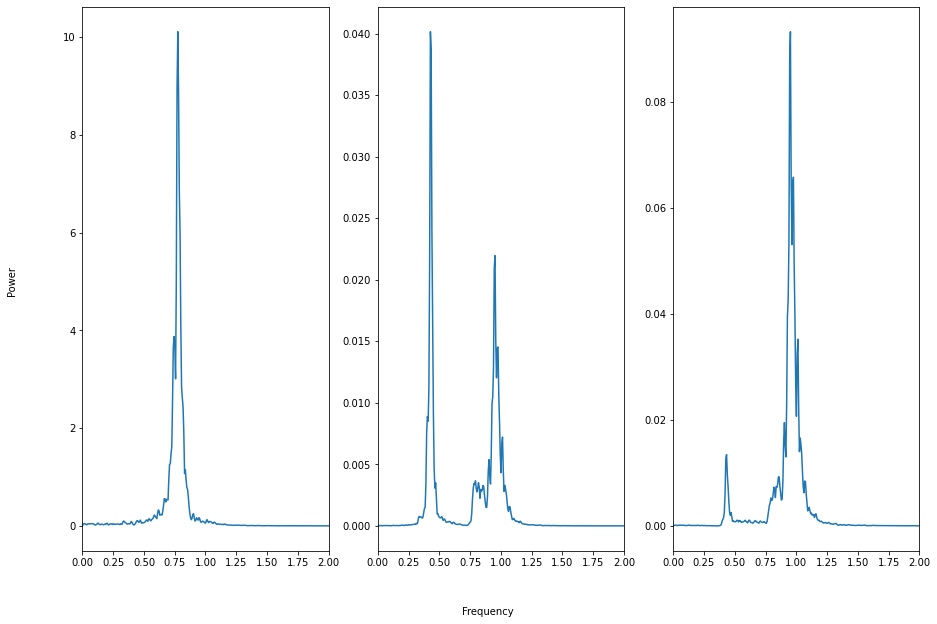

In [ ]:
z = vae.encoder.predict(yz[:,:])[0]
f, axs = plt.subplots(1,3,figsize=(15,10))
for i, ax in enumerate(f.axes):
  freqs, psd = signal.welch(z[:,i-1],fs=100,window=window,nperseg=nperseg,nfft=nfft)
  ax.plot(freqs,psd)
  ax.set_xlim(0, 2)
f.text(0.5, 0.04, 'Frequency', ha='center', va='center')
f.text(0.06, 0.5, 'Power', ha='center', va='center', rotation='vertical')

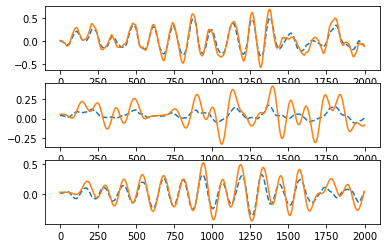

In [ ]:
z = vae.encoder.predict(y[:3000,:])[0]
ypred = vae.decoder.predict(z)
plt.subplot(3,1,1)
plt.plot(ypred[:2000,0],'--')
plt.plot(y[:2000,0])
plt.subplot(3,1,2)
plt.plot(ypred[:2000,1],'--')
plt.plot(y[:2000,1])
plt.subplot(3,1,3)
plt.plot(ypred[:2000,2],'--')
plt.plot(y[:2000,2])